#### 1. 단독다가구

In [152]:
import pandas as pd

target_csv = "../data/Bundang_20251215/실거래_단독다가구_분당구_2015이후.csv"
trade_df = pd.read_csv(target_csv, dtype=str)
trade_df = trade_df[trade_df["거래구분"] == '1']
trade_df.dtypes

계약년월       object
거래구분       object
번호         object
계약일        object
시군구일련번호    object
번지         object
주택유형       object
도로조건       object
연면적        object
대지면적       object
거래금액       object
월세         object
건축년도       object
도로명        object
해제사유발생일    object
거래유형       object
시군구명       object
법정동코드      object
dtype: object

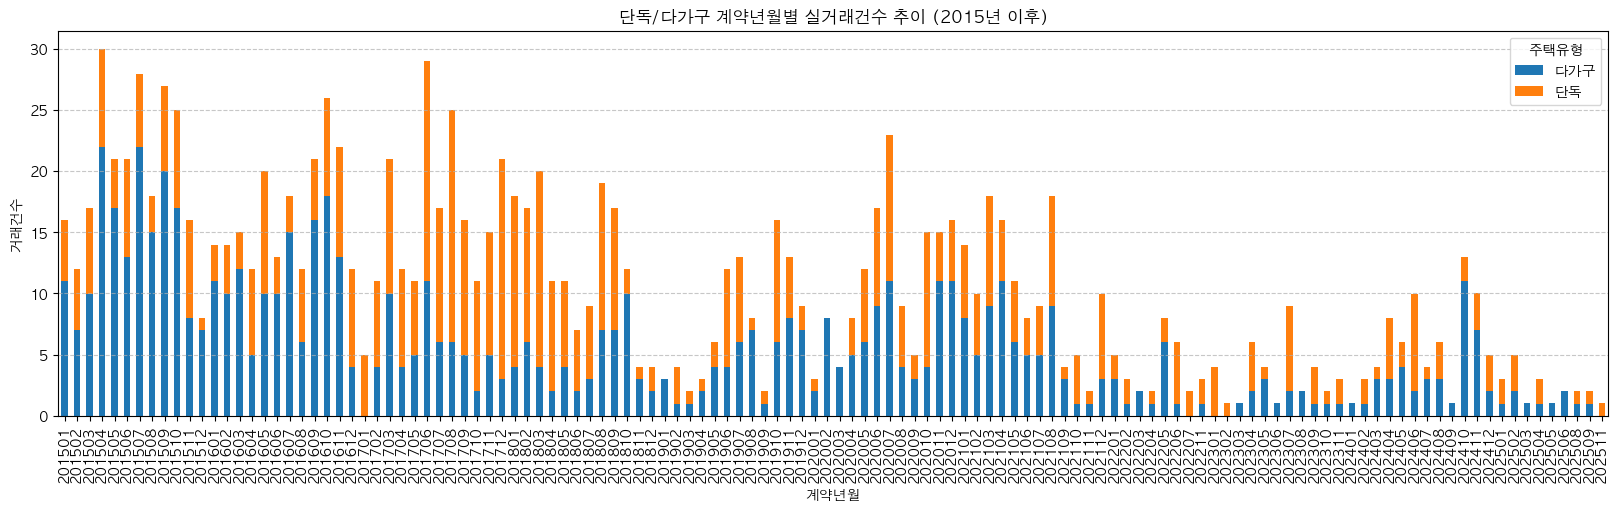

In [153]:
# 실거래 건수 계약년월별 추이 (주택유형 = 다가구/단독)
grouped = (
    trade_df[["계약년월","주택유형"]]
    .groupby(["계약년월","주택유형"])
    .size()
    .reset_index(name="count")
)
pivot_df = (
    grouped
    .pivot(index="계약년월", columns="주택유형", values="count")
    .fillna(0)
)

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False  # 마이너스(-) 깨짐 방지
pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(20,5)
)
plt.xlabel("계약년월")
plt.ylabel("거래건수")
plt.title("단독/다가구 계약년월별 실거래건수 추이 (2015년 이후)")
plt.legend(title="주택유형")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout
plt.show()

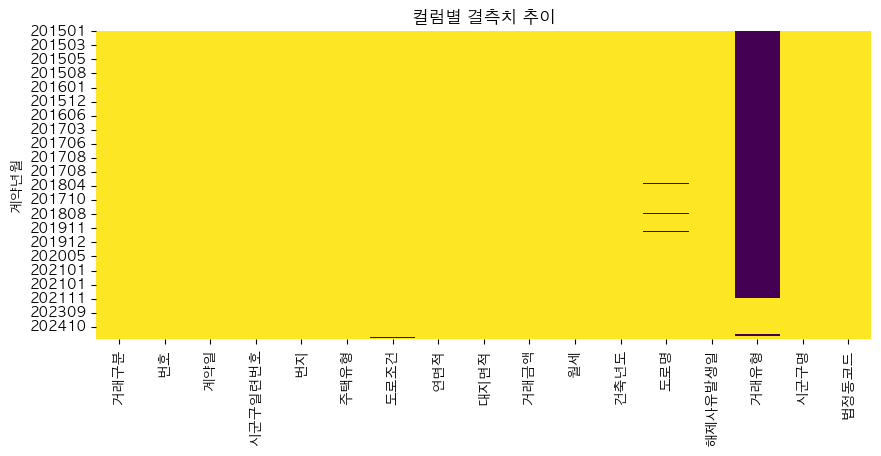

In [4]:
# 결측치 현황
df_heat = trade_df.set_index("계약년월")

na_counts = df_heat.isna().sum()
na_counts

import seaborn as sns
plt.figure(figsize=(10,4))
sns.heatmap(df_heat.isna(), cmap="viridis_r", cbar=False)
plt.title("컬럼별 결측치 추이")
plt.show()

#### <span style="color:yellow">1. 데이터 준비 - 건물 마스터</span>
- 건축물대장의 "표제부"와 "기본개요"을 읽는다.
- "표제부"의 PK를 포함하는 "기본개요"만 남기고 나머지는 필터링.
- "표제부"의 면적정보와 "기본개요"의 주소정보를 조인한다.
- 주소정보로부터 실거래와 조인할 "시군구명"과 "번지"를 만든다.

In [154]:
bldg_base_df = pd.read_csv("../data/Bundang_20251215/건축물대장_기본개요_분당구.csv", dtype=str)
bldg_hdr_df = pd.read_csv("../data/Bundang_20251215/건축물대장_표제부_분당구.csv", dtype=str)

# 표제부(bldg_dr_df)의 PK를 포함하는 기본개요(bldg_base_df)만 필터링
bldg_addr_df = bldg_base_df[bldg_base_df['관리_건축물대장_PK'].isin(bldg_hdr_df['관리_건축물대장_PK'])]

# 표제부와 기본개요를 조인
bldg_df = pd.merge(
            bldg_hdr_df[['관리_건축물대장_PK','대지_면적', '연면적', '주_용도_코드_명', '기타_용도']], 
            bldg_addr_df[['관리_건축물대장_PK', '대지_위치', '도로명_대지_위치']], 
            on="관리_건축물대장_PK", 
            how="left"
            )

# 번지를 masking할 함수
import re
def mask_addr(addr):
    if not isinstance(addr, str):
        addr = str(addr)

    splitted = addr.split()
    result = splitted[:-1]

    bunji = re.sub(r'[^0-9-]', '', splitted[-1])    # 580-9번지 -> 580-9
    bunji = bunji.split('-')[0]     # 580-9 -> 580

    if len(bunji) == 0:
        masked = splitted[-1]     # 예, 경기도 성남시 분당구 대장동 블록
    elif len(bunji) == 1:
        masked = '*'
    else:
        first_char = bunji[0]
        masked_part = '*' * (len(bunji) - 1)
        masked = first_char + masked_part

    return " ".join(result), masked

# masking 함수를 적용하여 "시군구명"과 "번지" 필드를 생성
bldg_df[["시군구명", "번지"]] = pd.DataFrame(bldg_df["대지_위치"].apply(mask_addr).to_list())

# "대지_면적"과 "연면적" 필드는 float로 변환
bldg_df["대지_면적"] = bldg_df["대지_면적"].astype(float)
bldg_df["연면적"] = bldg_df["연면적"].astype(float)

bldg_df.dtypes

관리_건축물대장_PK     object
대지_면적          float64
연면적            float64
주_용도_코드_명       object
기타_용도           object
대지_위치           object
도로명_대지_위치       object
시군구명            object
번지              object
dtype: object

#### <span style="color:yellow">2. 실거래 매매 이력 (특정 년월 기준)</span>

In [155]:
# 실거래가 2025년도
trade_df = pd.read_csv("../data/Bundang_20251215/실거래_단독다가구_분당구_2015이후.csv", dtype=str)

# "대지_면적"과 "연면적" 필드는 float로 변환
trade_df["대지면적"] = trade_df["대지면적"].astype(float)
trade_df["연면적"] = trade_df["연면적"].astype(float)

#trade_df["실거래ID"] = trade_df.index
#trade_df = trade_df[trade_df["계약년월"].str.startswith("2024") & (trade_df["거래구분"] == '1')]

trade_df.dtypes

계약년월        object
거래구분        object
번호          object
계약일         object
시군구일련번호     object
번지          object
주택유형        object
도로조건        object
연면적        float64
대지면적       float64
거래금액        object
월세          object
건축년도        object
도로명         object
해제사유발생일     object
거래유형        object
시군구명        object
법정동코드       object
dtype: object

#### <span style="color:yellow">3. 1단계. 시군구 + 번지 조인</span>

In [156]:
# 시군구명에 space가 있고 없고 차이를 제거. 예, "경기도 성남시분당구 판교동"
trade_df['시군구명'] = trade_df['시군구명'].str.replace(' ', '')
bldg_df['시군구명'] = bldg_df['시군구명'].str.replace(' ', '')

# join에 대비하여 컬럼명 변경
trade_df.rename(columns={"연면적" : "연면적_t", "대지면적" : "대지면적_t", "도로명" : "도로명_t"}, inplace=True)
bldg_df.rename(columns={"연면적" : "연면적_b", "대지_면적" : "대지면적_b", "도로명_대지_위치" : "도로명_b", "대지_위치" : "주소","주_용도_코드_명":"주용도","기타_용도":"기타용도"}, inplace=True)

# 시군구 + 번지(마스크된)으로만 조인
join_df = pd.merge(
            trade_df, 
            bldg_df, 
            on=["시군구명", "번지"], 
            how="left").sort_values(["번호"])

# 건물.주용도 != '단독주택'인 경우 필터링
#all_df = all_df[(all_df['주_용도_코드_명'] == '단독주택')]

join_df['STEP1'] = ~join_df['관리_건축물대장_PK'].isna()


#### <span style="color:yellow">3. 2단계. 도로명으로 필터링</span>

In [157]:
# 도로명이 일치하는 건만
join_df['STEP2'] = join_df.apply(lambda row: str(row["도로명_t"]) in str(row["도로명_b"]), axis=1)

#### <span style="color:yellow">3. 3단계. 건물 주용도코드 필터링</span>

In [158]:
join_df['STEP3'] = (join_df['주용도'] == '단독주택')

#### <span style="color:yellow">3. 4단계. 면적 비교 필터링</span>

In [159]:
join_df['STEP4'] = (join_df['연면적_t'].astype(float) == join_df['연면적_b'].astype(float))

In [ ]:
# CSV 파일 저장
join_df.to_csv("join_2024_df.csv", index=False, encoding='euc-kr')

#### <span style="color:yellow">4. 매핑건수 집계</span>

In [161]:
def groupby_count(df, mask):
    mask_df = df[mask]
    cnt_df = mask_df[['번호','주택유형','주소']].groupby(['번호','주택유형']).count()
    avg_df = cnt_df.groupby(['주택유형']).aggregate(['mean'])
    zero_cnt = len(cnt_df[cnt_df['주소'] == 0])
    print(avg_df)
    print("zero cnt : ", zero_cnt)

groupby_count(join_df, join_df['STEP1'])
groupby_count(join_df, join_df['STEP1'] & join_df['STEP2'])
groupby_count(join_df, join_df['STEP1'] & join_df['STEP2'] & join_df['STEP3'])
groupby_count(join_df, join_df['STEP1'] & join_df['STEP2'] & join_df['STEP3'] & join_df['STEP4'])

              주소
            mean
주택유형            
다가구   568.611708
단독    358.270107
zero cnt :  0
             주소
           mean
주택유형           
다가구   43.211397
단독    32.166484
zero cnt :  0
             주소
           mean
주택유형           
다가구   38.127548
단독    27.658278
zero cnt :  0
            주소
          mean
주택유형          
다가구   1.162602
단독    1.008333
zero cnt :  0


#### <span style="color:yellow">5. 매핑건수 플롯</span>

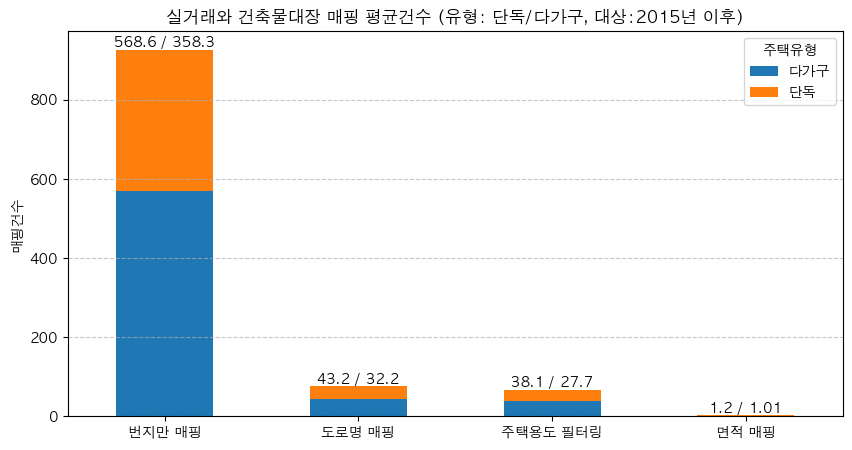

In [168]:

import pandas as pd
df = pd.DataFrame(
        [[568.6, 358.3], [43.2, 32.2], [38.1, 27.7], [1.2, 1.01]], 
        columns=["다가구", "단독"], 
        index = ['번지만 매핑', '도로명 매핑', '주택용도 필터링', '면적 매핑']
    )


import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False  # 마이너스(-) 깨짐 방지
df.plot(
    kind="bar",
    stacked=True,
    figsize=(10,5)
)
for i in range(len(df)):
    y_pos = df.iloc[i]['다가구'] + df.iloc[i]['단독']
    text = f"{df.iloc[i]['다가구']} / {df.iloc[i]['단독']}"
    plt.text(
        i,
        y_pos,
        str(text),
        ha='center',
        va='bottom',
        fontweight='bold'
    )

#plt.xlabel("매핑방법")
plt.ylabel("매핑건수")
plt.title("실거래와 건축물대장 매핑 평균건수 (유형: 단독/다가구, 대상:2015년 이후)")
plt.legend(title="주택유형")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout
plt.show()